
# Classification and KNN with Churn data

_By: Lujain Felemban_
FOR OW Technical Assignment

---

The dataset, ChurnData.csv, was provided to be analyzed and to create a bianry KNN classifier on the variable (Exited). No additional information was provided. 



In [46]:
#import the relevent libraries for data reading, cleaning, and analysis
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 1. Load the Churn data

In [47]:
df = pd.read_csv('ChurnData.csv')

### 2. Data Exploration and Cleaning

In [48]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,NaN,42,2,0.00,1,1,1,10134888.0,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,11254258.0,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,11393157.0,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,0.0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,7908410.0,0


In [49]:
df.shape

(10000, 14)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             8571 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    8576 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [51]:
# here we drop the row number column since it is redundant with the index
# we also set CustomerId column type to string since it is a qualtitative variable
df.drop('RowNumber', axis=1, inplace=True)
df.CustomerId = df.CustomerId.astype(str)

In [52]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,8.576000e+03,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,1.376025e+05,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,1.227497e+06,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000e+00,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,5.127141e+04,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,1.005619e+05,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,1.494056e+05,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,1.009485e+08,1.000000


##### Numerical Variables at a glance
There are some potential outliers in variables here:

- Estimated Salary has at least one outlier at the max end of the range.
- CreditScore might have an outlier at the min end.

We will deal with those once we take a deeper look

## Dealing with Missing Data

In [53]:
df.isnull().sum()

CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender             1429
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary    1424
Exited                0
dtype: int64

In [54]:
# Check if those 1420-ish nulls from both columns are in the same rows
sum(( df.Gender.isna() ) & (df.EstimatedSalary.isna()))

0

*Initial plan for dealing with those values*

We will drop outliers in estimated salary then impute with mean/median after checking the distribution
For gender, we will drop na for now, but given more time we could impute with a classification (gender) or regresison (estimatedsalary) for those columns

### Dealing with the EstimatedSalary Column

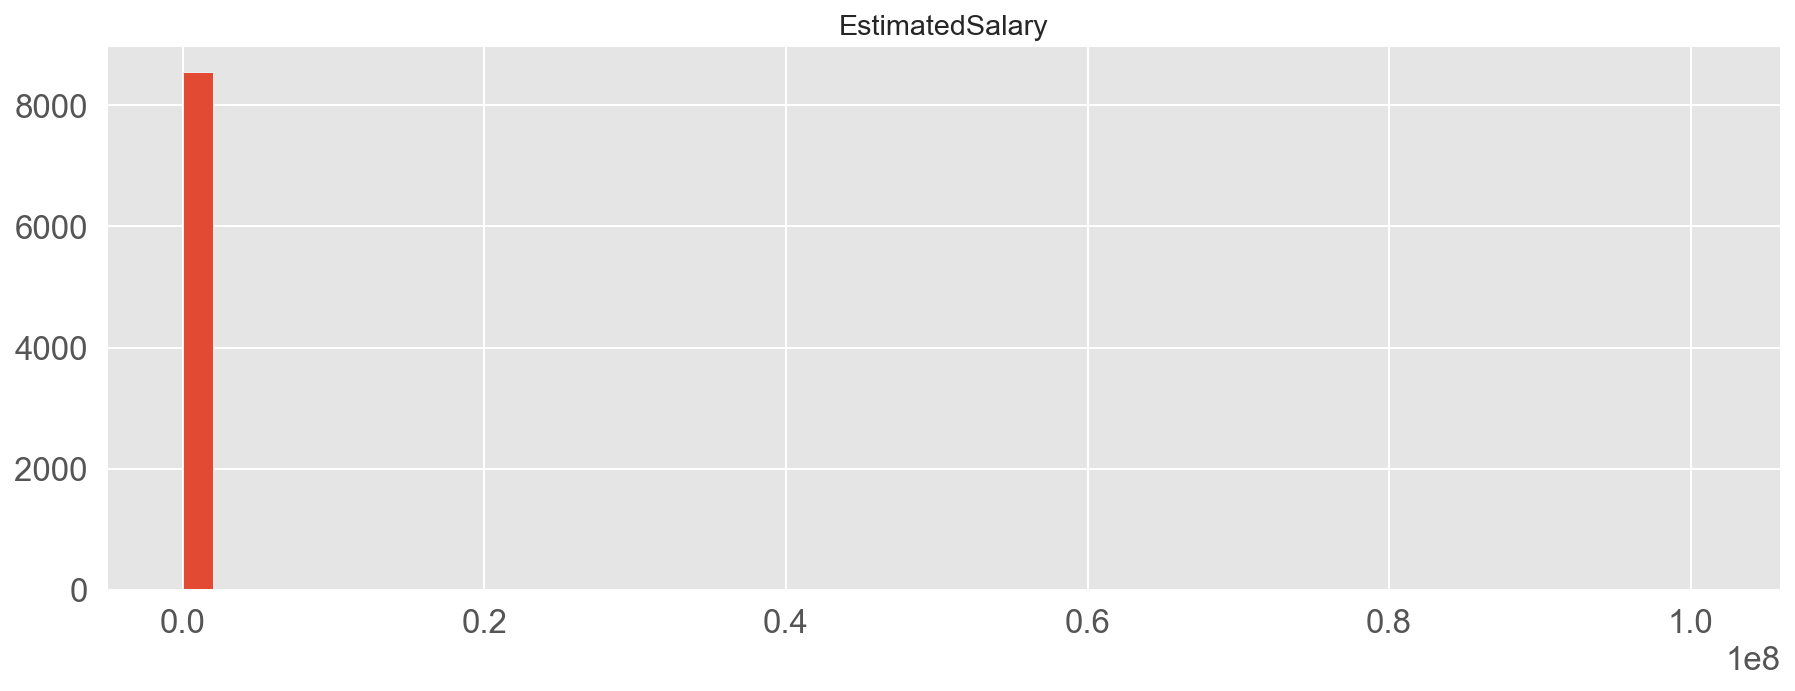

In [63]:
# we first look at the distribution
df[['EstimatedSalary']].hist(figsize = (15, 5), bins=50);

From the plot range above it looks like we have one (maybe a few) outliers on the maximum end. So we check the top salaries in our dataset

In [59]:
df[['CustomerId', 'EstimatedSalary']].sort_values(by='EstimatedSalary', ascending=False).head(5)

,CustomerId,EstimatedSalary
815,15619708,100948502.0
13,15691483,19085779.0
20,15577657,17088617.0
26,15736816,17004195.0
18,15661507,15868481.0


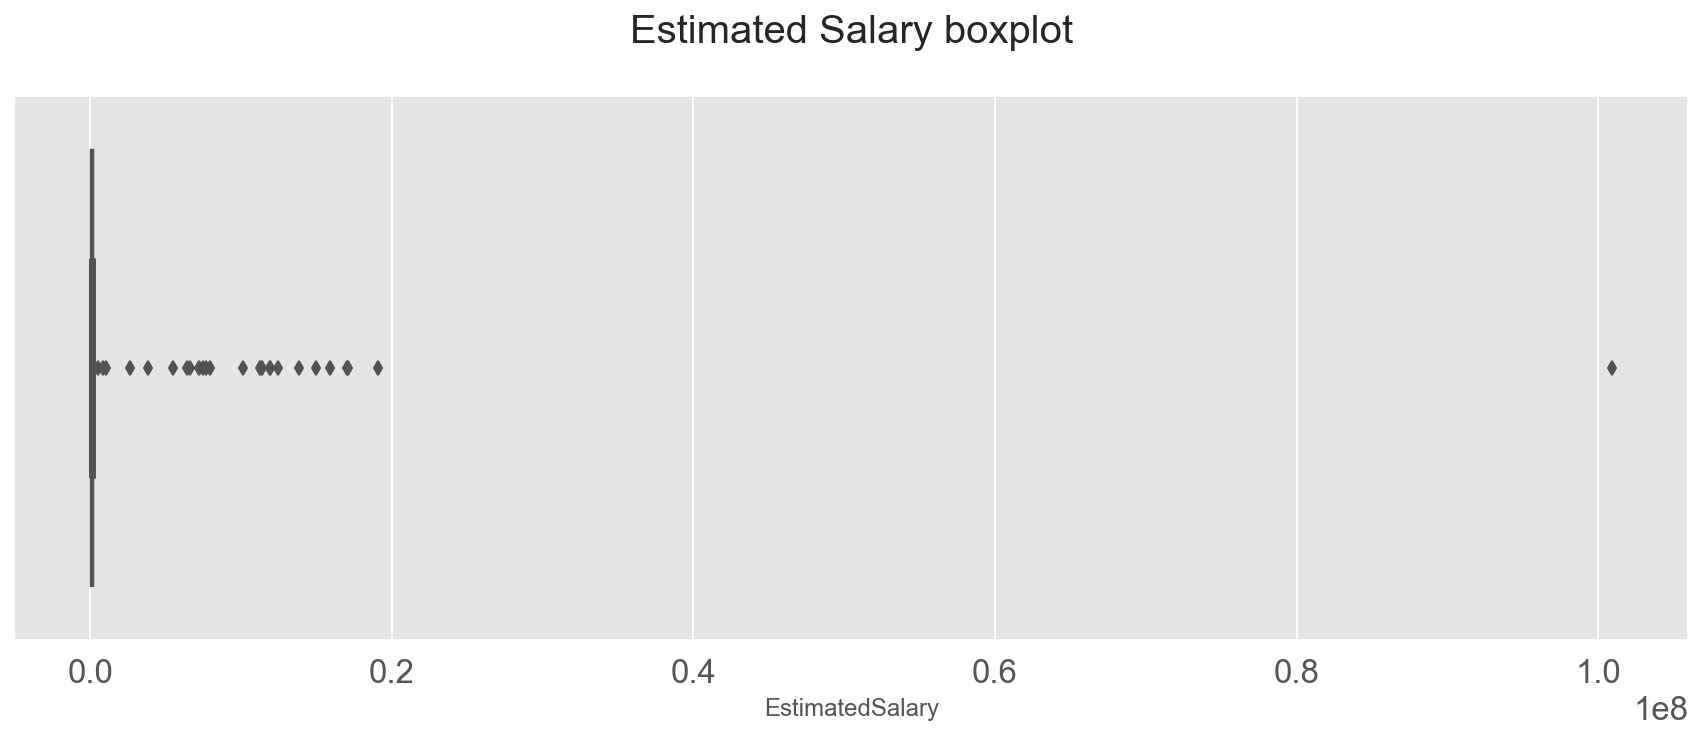

In [77]:
# Estimated Salary
fig = plt.figure(figsize=(15,5))
ax = fig.gca()

sns.boxplot('EstimatedSalary', data=df, orient='h',
                fliersize=5, linewidth=1.5, notch=True,
                saturation=0.5, ax=ax)

ax.set_title('Estimated Salary boxplot\n', fontsize=20)

plt.show()

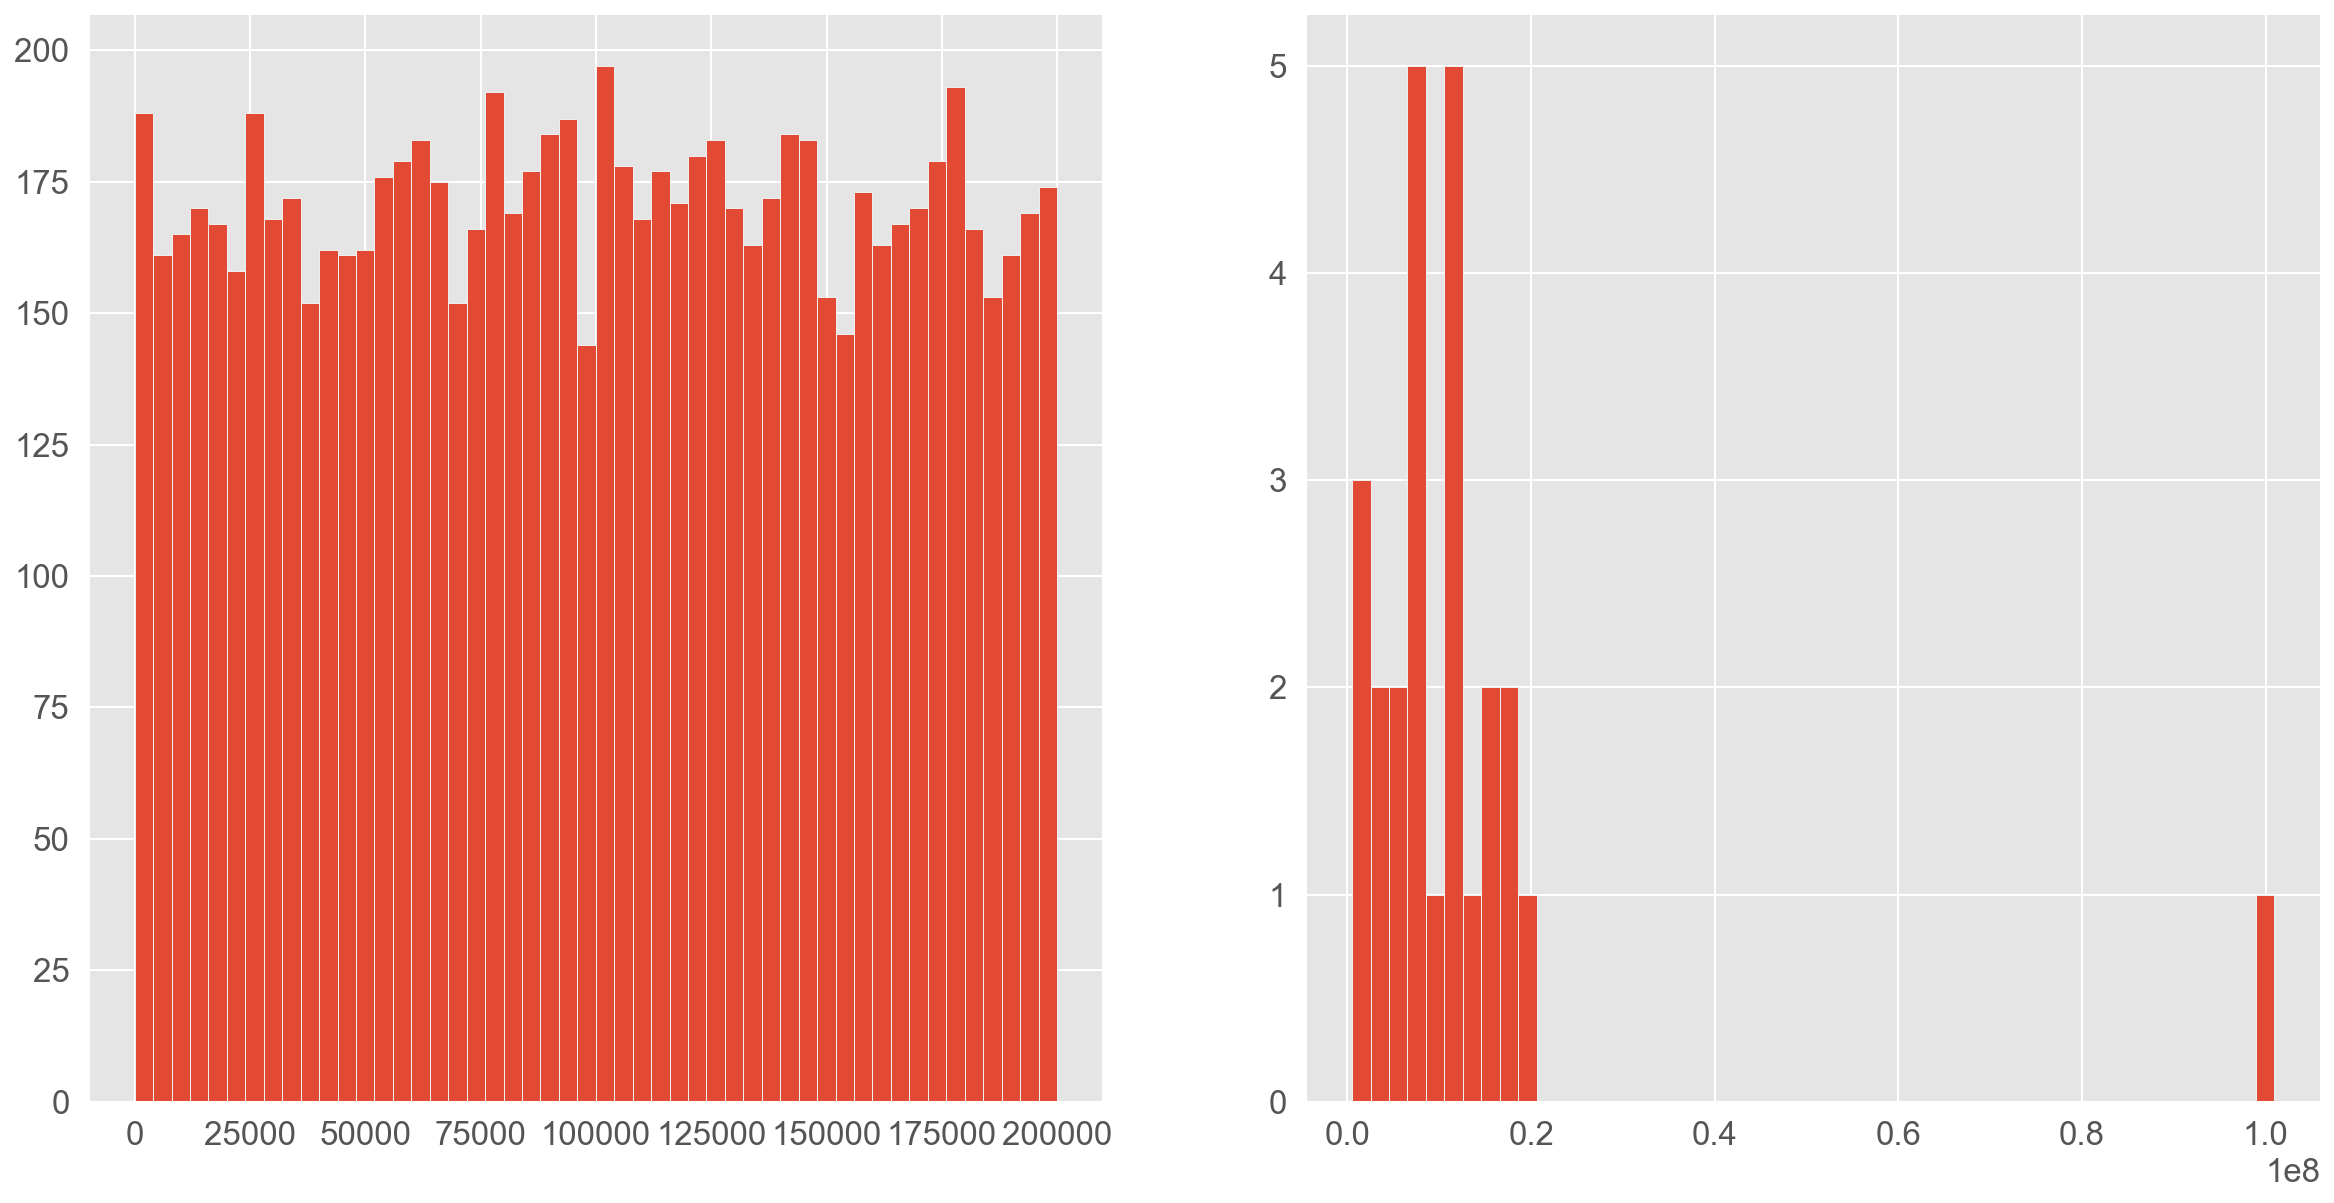

In [65]:
# we take a more closer look at the concentration below the 200,000 

plt.subplots(1,2, figsize=(20,10))

plt.subplot(121)
df.loc[df.EstimatedSalary < 200000, "EstimatedSalary"].hist( bins=50)

plt.subplot(122)
df.loc[df.EstimatedSalary > 200000, "EstimatedSalary"].hist( bins=50);


it looks like for the 0-200,000 range we have a uniform distribution. we check how many observation above 200,000 

In [73]:
print(f'Number of observations with a salary less than 200,000 is {sum(df.EstimatedSalary < 200000)} \n\
Number of observations with a salary more than 200,000 is {sum(df.EstimatedSalary > 200000)}') 

Number of observations with a salary less than 200,000 is 8551 
Number of observations with a salary more than 200,000 is 25


In [78]:
print(df[(df.EstimatedSalary < 200000 ) | df.EstimatedSalary.isnull()].shape)
# we drop those 25 rows
df = df[(df.EstimatedSalary < 200000 ) | df.EstimatedSalary.isnull()]

(9975, 13)


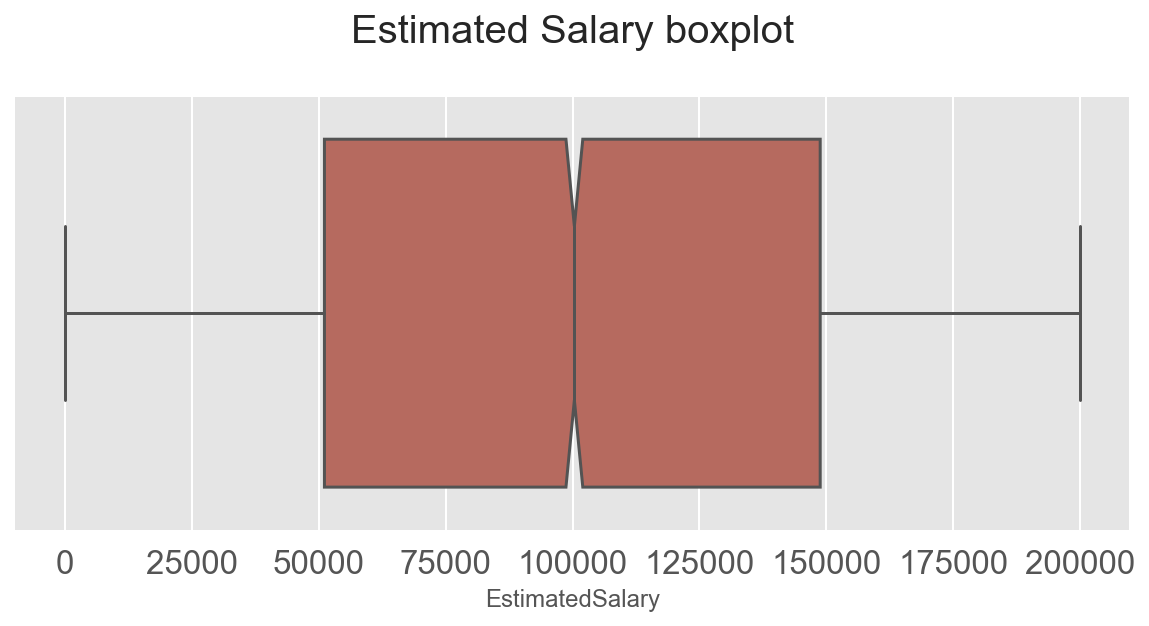

In [79]:
# we look at the EstimatedSalary after
fig = plt.figure(figsize=(10,4))
ax = fig.gca()

sns.boxplot('EstimatedSalary', data=df, orient='h',
                fliersize=5, linewidth=1.5, notch=True,
                saturation=0.5, ax=ax)

ax.set_title('Estimated Salary boxplot\n', fontsize=20)

plt.show()

In [80]:
#now that we do not have any outliers, we impute the missing value with the mean
df['EstimatedSalary'].fillna((df['EstimatedSalary'].mean()), inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9975 entries, 3 to 9999
Data columns (total 13 columns):
CustomerId         9975 non-null object
Surname            9975 non-null object
CreditScore        9975 non-null int64
Geography          9975 non-null object
Gender             8550 non-null object
Age                9975 non-null int64
Tenure             9975 non-null int64
Balance            9975 non-null float64
NumOfProducts      9975 non-null int64
HasCrCard          9975 non-null int64
IsActiveMember     9975 non-null int64
EstimatedSalary    9975 non-null float64
Exited             9975 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 1.1+ MB


#### Now we look at the gender column
we already decided we will drop the rows with null for gender

In [83]:
#since gender takes only two categories we will make into a binary (0, 1) column
df['Gender'].replace({'Female':0,'Male':1},inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [84]:
# check to see our replacement
df.sample(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2920,15714658,Yates,696,France,0.0,33,4,0.00,2,1,1,73371.65,0
341,15786170,Tien,659,France,1.0,31,4,118342.26,1,0,0,161574.19,0
8513,15740602,Boyle,674,Germany,0.0,27,4,111568.01,1,0,1,22026.18,0
160,15692132,Wilkinson,717,Spain,0.0,22,6,101060.25,1,0,1,84699.56,0
3057,15598840,Moretti,680,France,1.0,33,1,123082.08,1,1,0,134960.98,0


In [86]:
df.Gender.value_counts()

1.0    4643
0.0    3907
Name: Gender, dtype: int64

## The Other Variables at a Glance

In [87]:
# here we creat a histogram for all of our continuous quantitative data

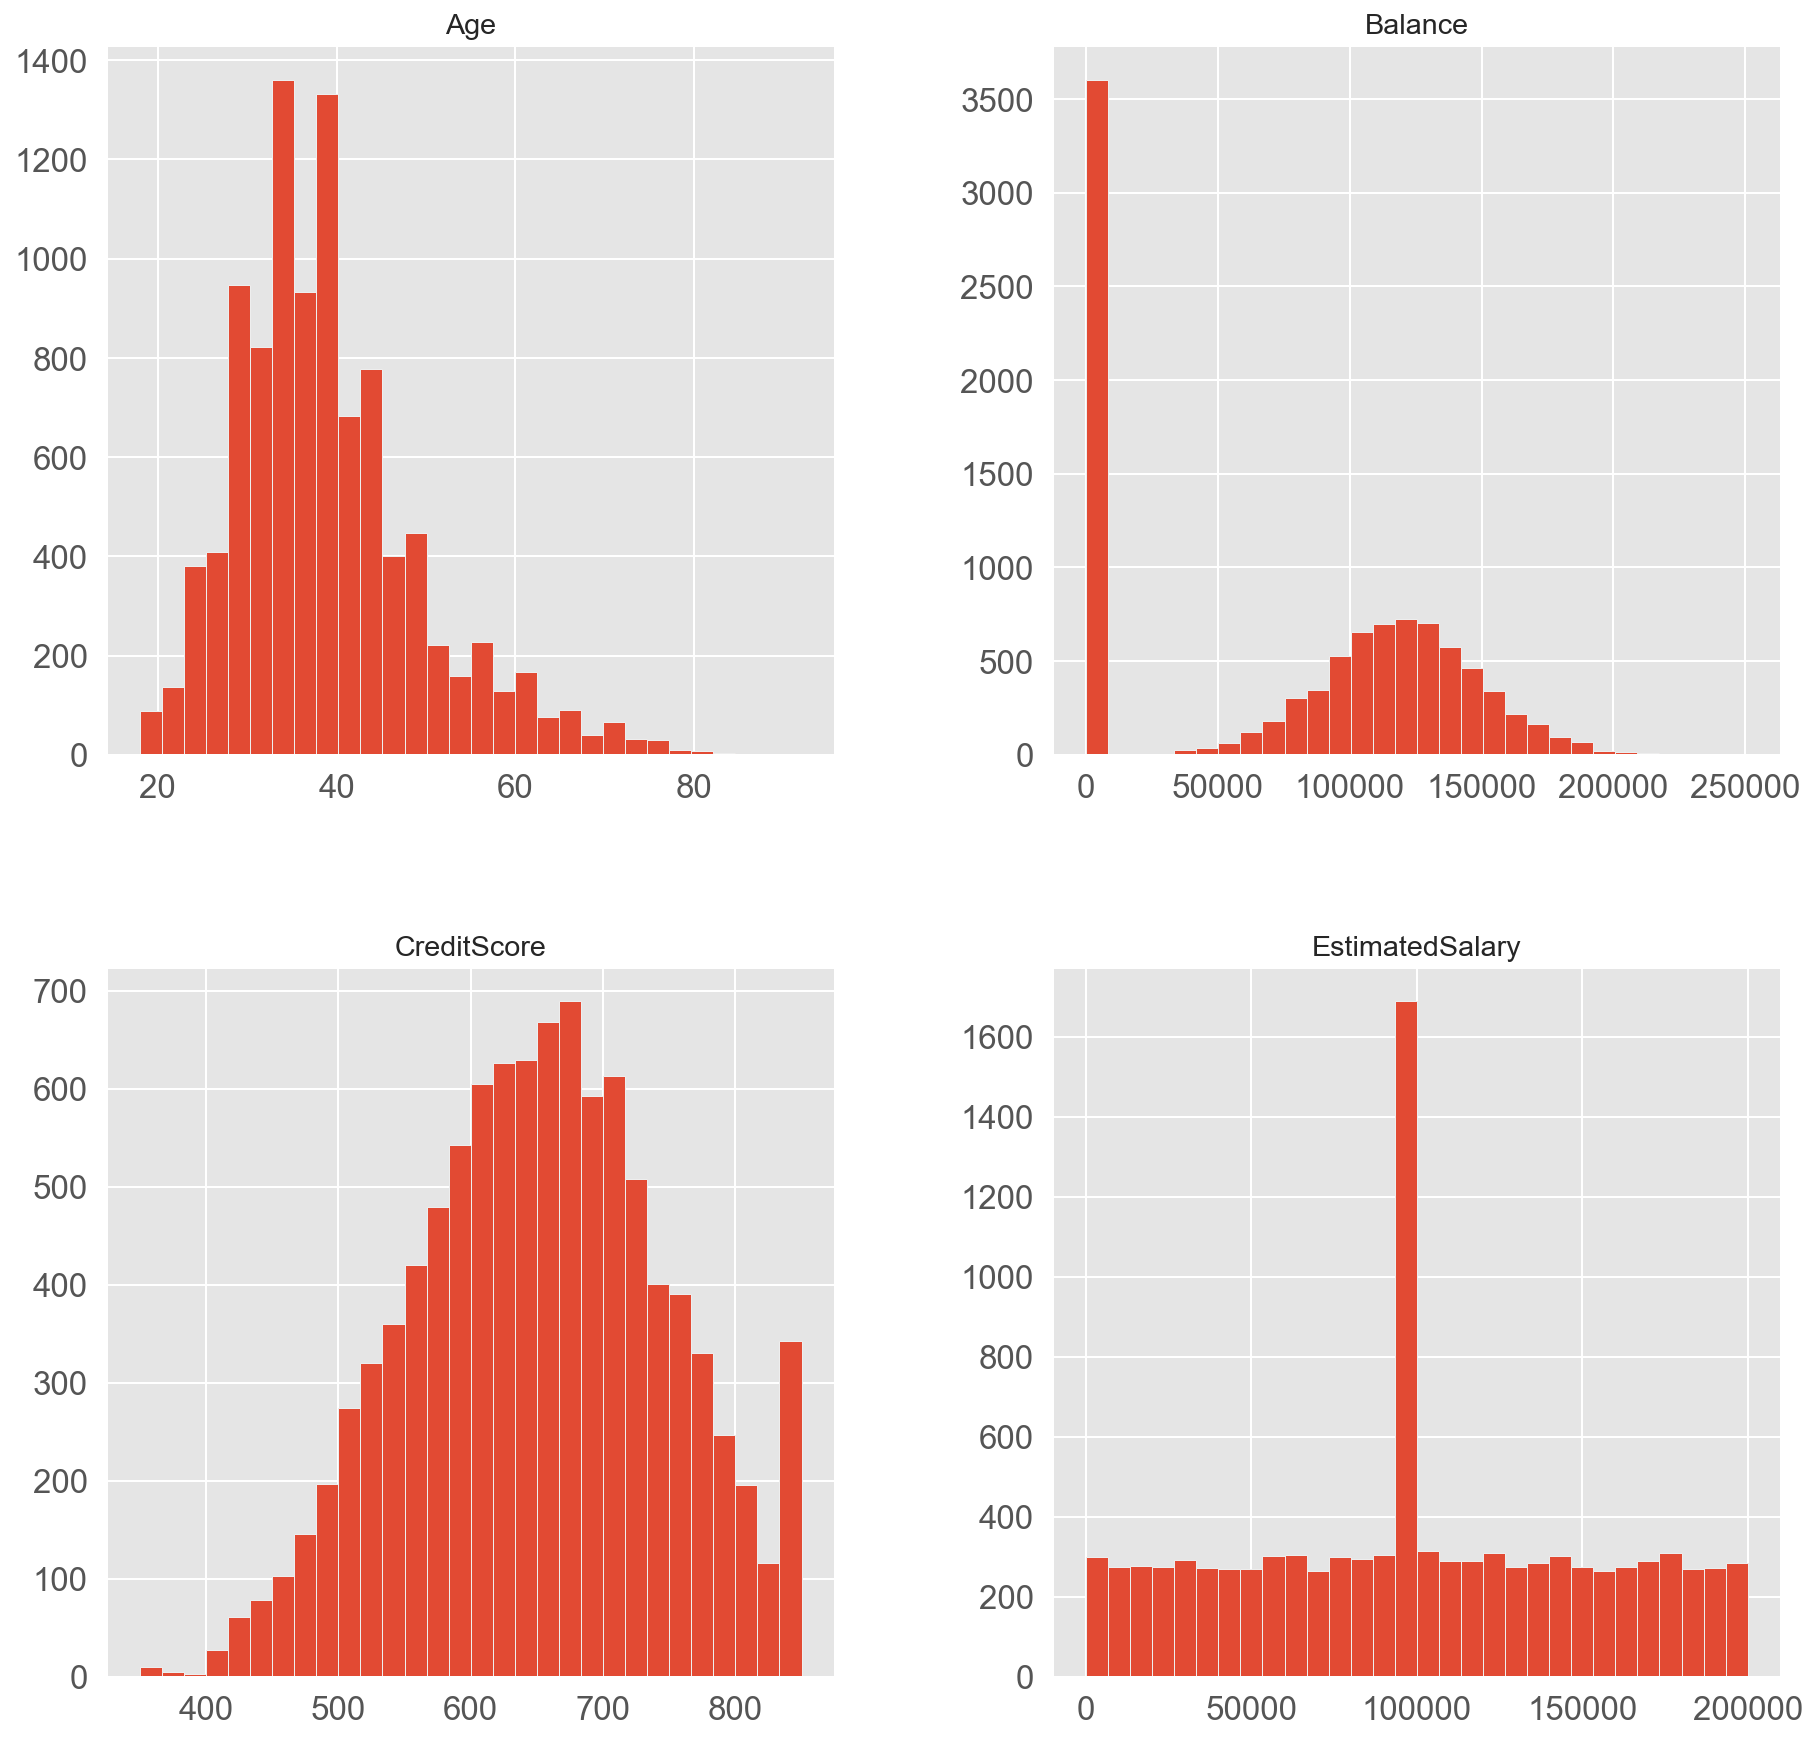

In [89]:
df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']].hist(figsize = (15, 15), bins=30);

In [90]:
# here we create bar charts for all of our binary/categorical data

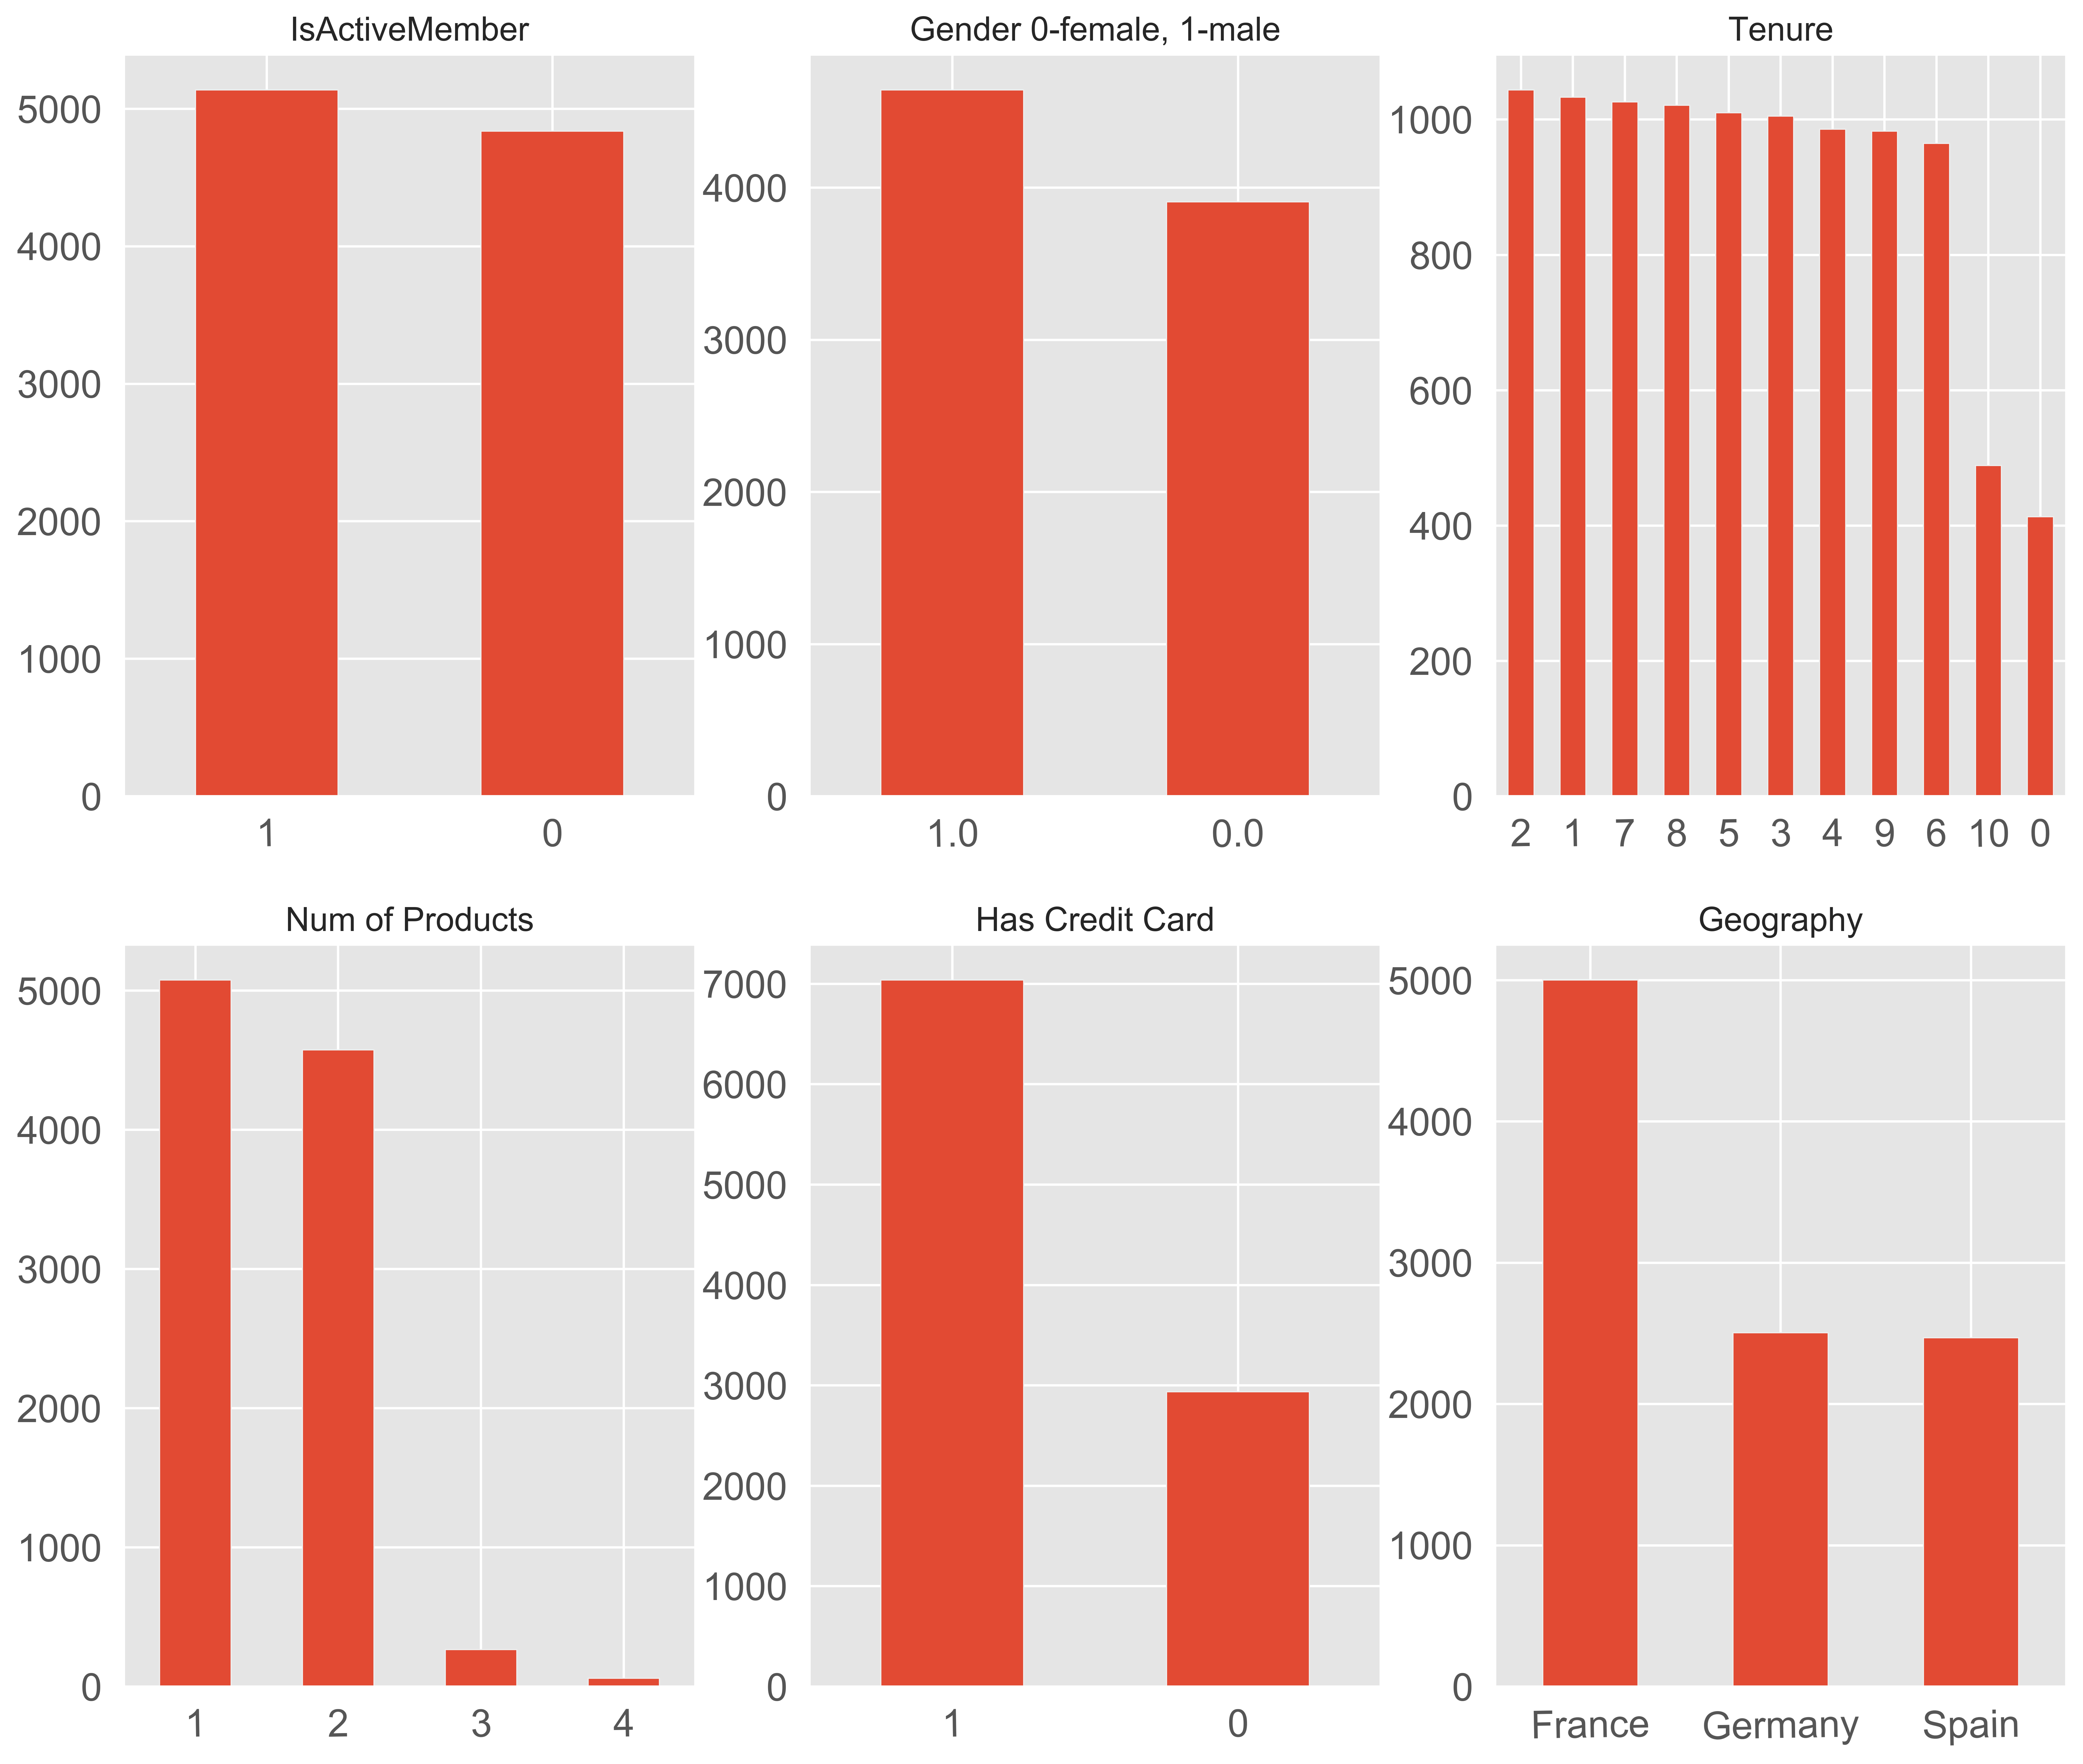

In [153]:
fig = plt.figure(figsize=(15,20), dpi=300)

ax1 = plt.subplot(3, 3, 1)
ax1.set_title('IsActiveMember')
df.IsActiveMember.value_counts().plot(kind='bar', rot=1)

ax2 = plt.subplot(3, 3, 2)
ax2.set_title('Gender 0-female, 1-male')
df.Gender.value_counts().plot(kind='bar', rot=1)

ax3 = plt.subplot(3, 3, 3)
ax3.set_title('Tenure')
df.Tenure.value_counts().plot(kind='bar', rot=1)

ax4 = plt.subplot(3, 3, 4)
ax4.set_title('Num of Products')
df.NumOfProducts.value_counts().plot(kind='bar', rot=1)

ax5 = plt.subplot(3, 3, 5)
ax5.set_title('Has Credit Card')
df.HasCrCard.value_counts().plot(kind='bar', rot=1)

ax6 = plt.subplot(3, 3, 6)
ax6.set_title('Geography')
df.Geography.value_counts().plot(kind='bar', rot=1);

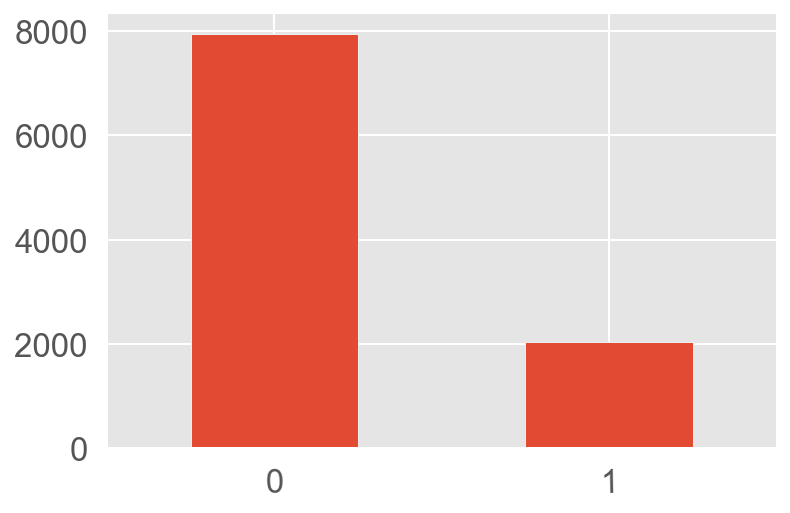

In [157]:
df.Exited.value_counts().plot(kind='bar', rot=1);

from the chart above, it looks like we have imbalanced data. Lets check below whether or not the ratio changes based on any certain categorical  variable. We also might consider balancing our data when modelling.

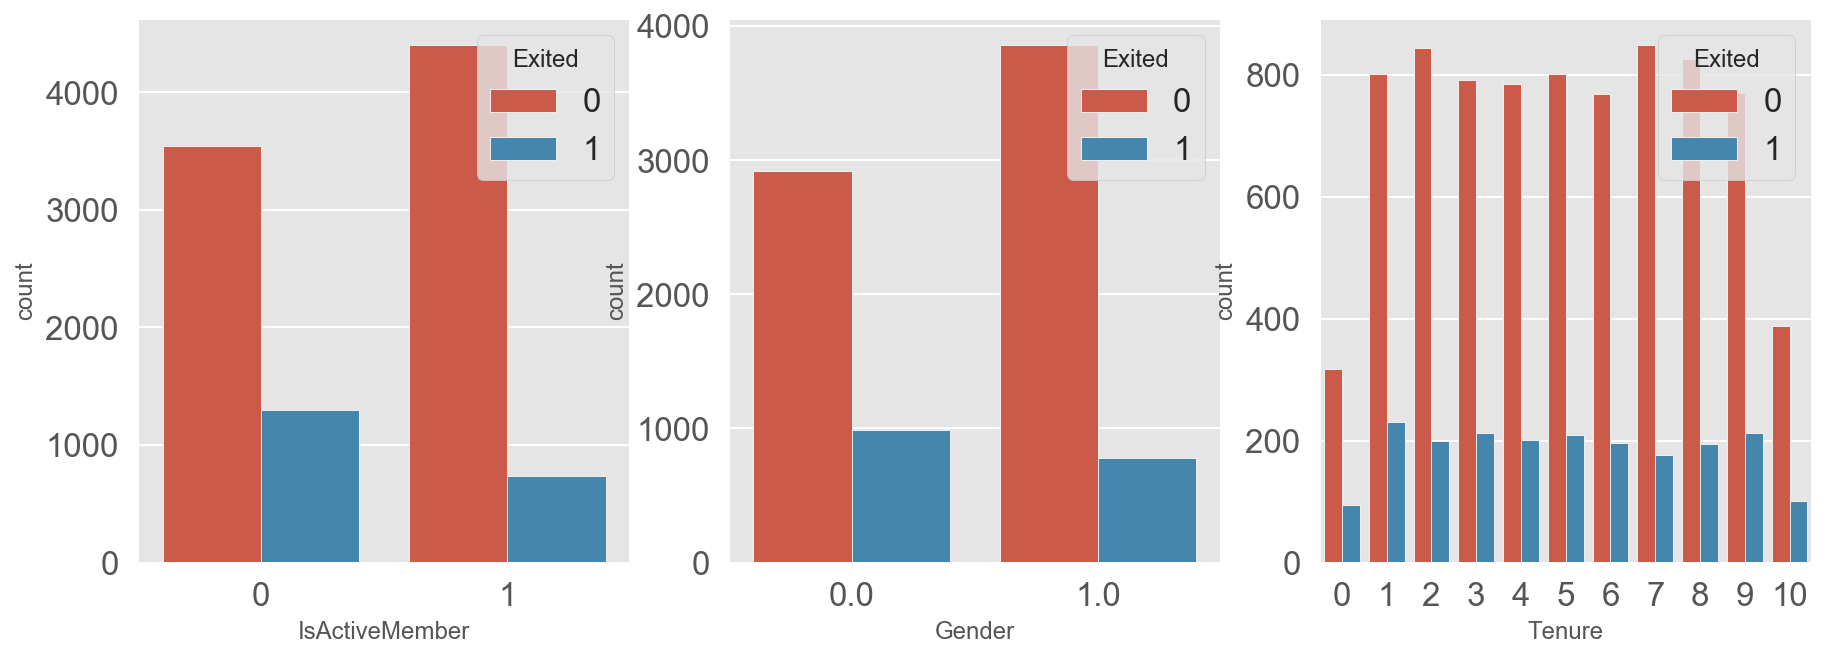

In [156]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.countplot(x="IsActiveMember", hue="Exited", data=df, ax=axes[0])
ax = sns.countplot(x="Gender", hue="Exited", data=df, ax=axes[1])
ax = sns.countplot(x="Tenure", hue="Exited", data=df, ax=axes[2])

from the charts above it does not look like the ration of churn changes much 

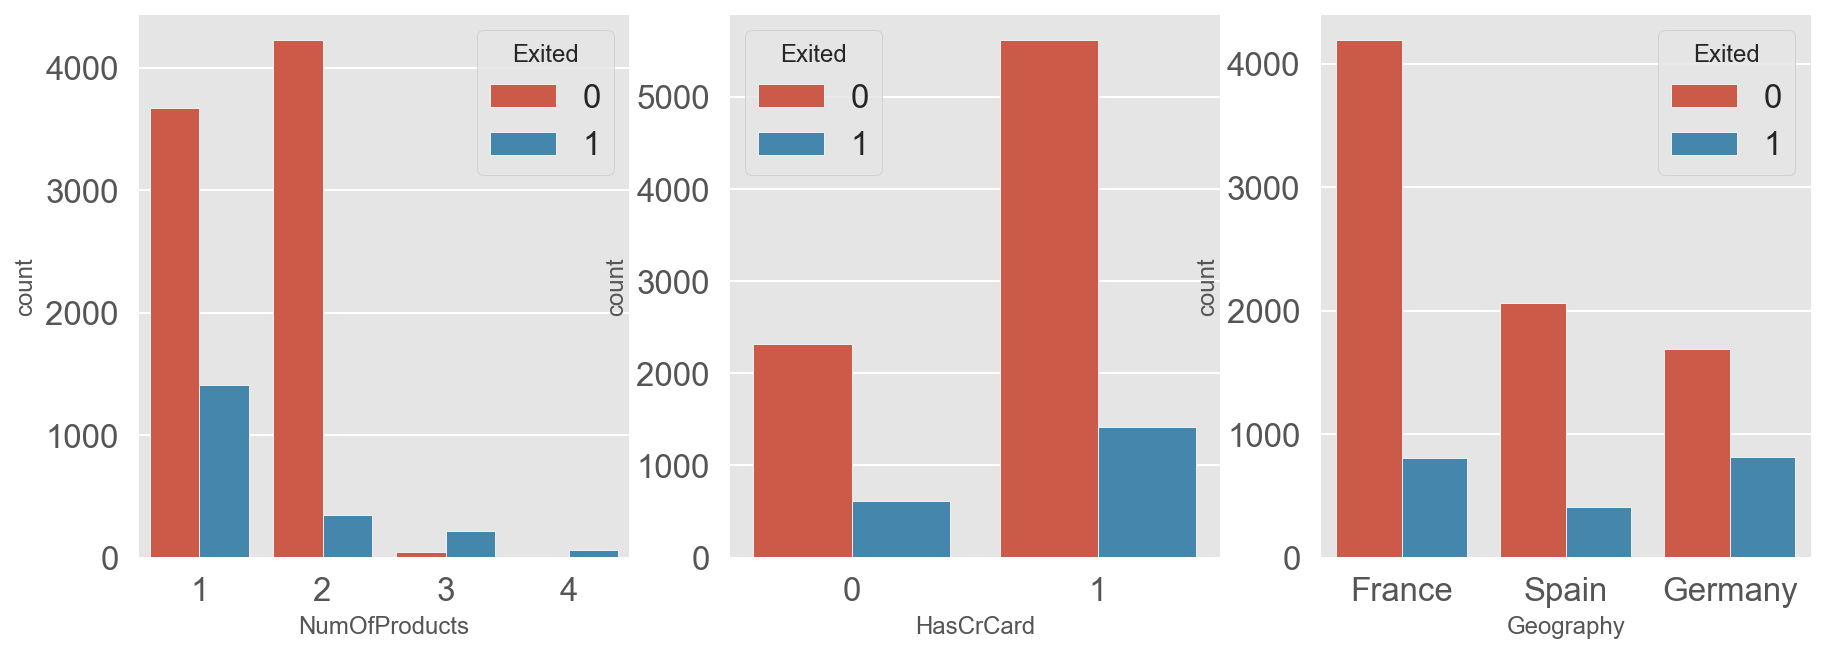

In [155]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.countplot(x="NumOfProducts", hue="Exited", data=df, ax=axes[0])
ax = sns.countplot(x="HasCrCard", hue="Exited", data=df, ax=axes[1])
ax = sns.countplot(x="Geography", hue="Exited", data=df, ax=axes[2])

from the charts above, number of products < 2 might have a more churn ratio compared customers with lower numbers of products. 

The Customer from Germany looks like they have a higher churn (Exited = 1) ratio comapred to those from Spain and France

#### Lets Plot variables with potential outliers using boxplots


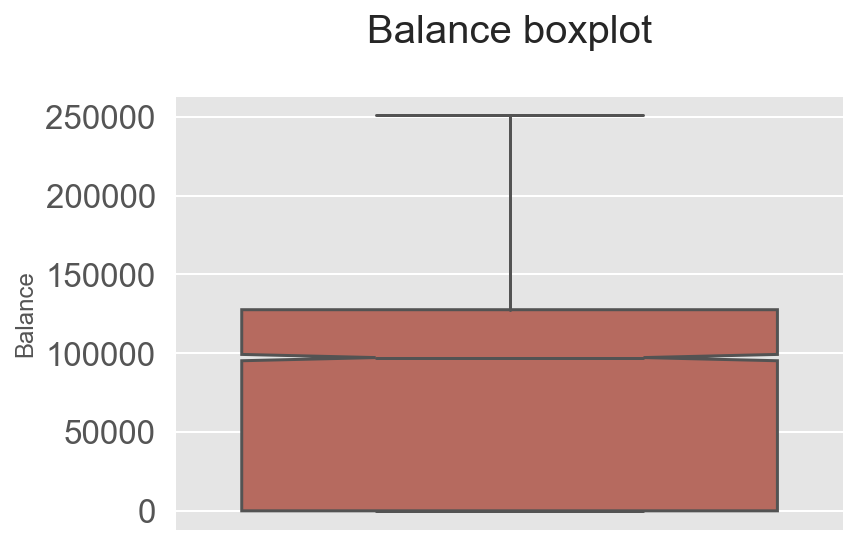

In [158]:
# Balance Boxplot
fig = plt.figure(figsize=(6,4))
ax = fig.gca()

sns.boxplot('Balance', data=df, orient='v',
                fliersize=5, linewidth=1.5, notch=True,
                saturation=0.5, ax=ax)

ax.set_title('Balance boxplot\n', fontsize=20)

plt.show()

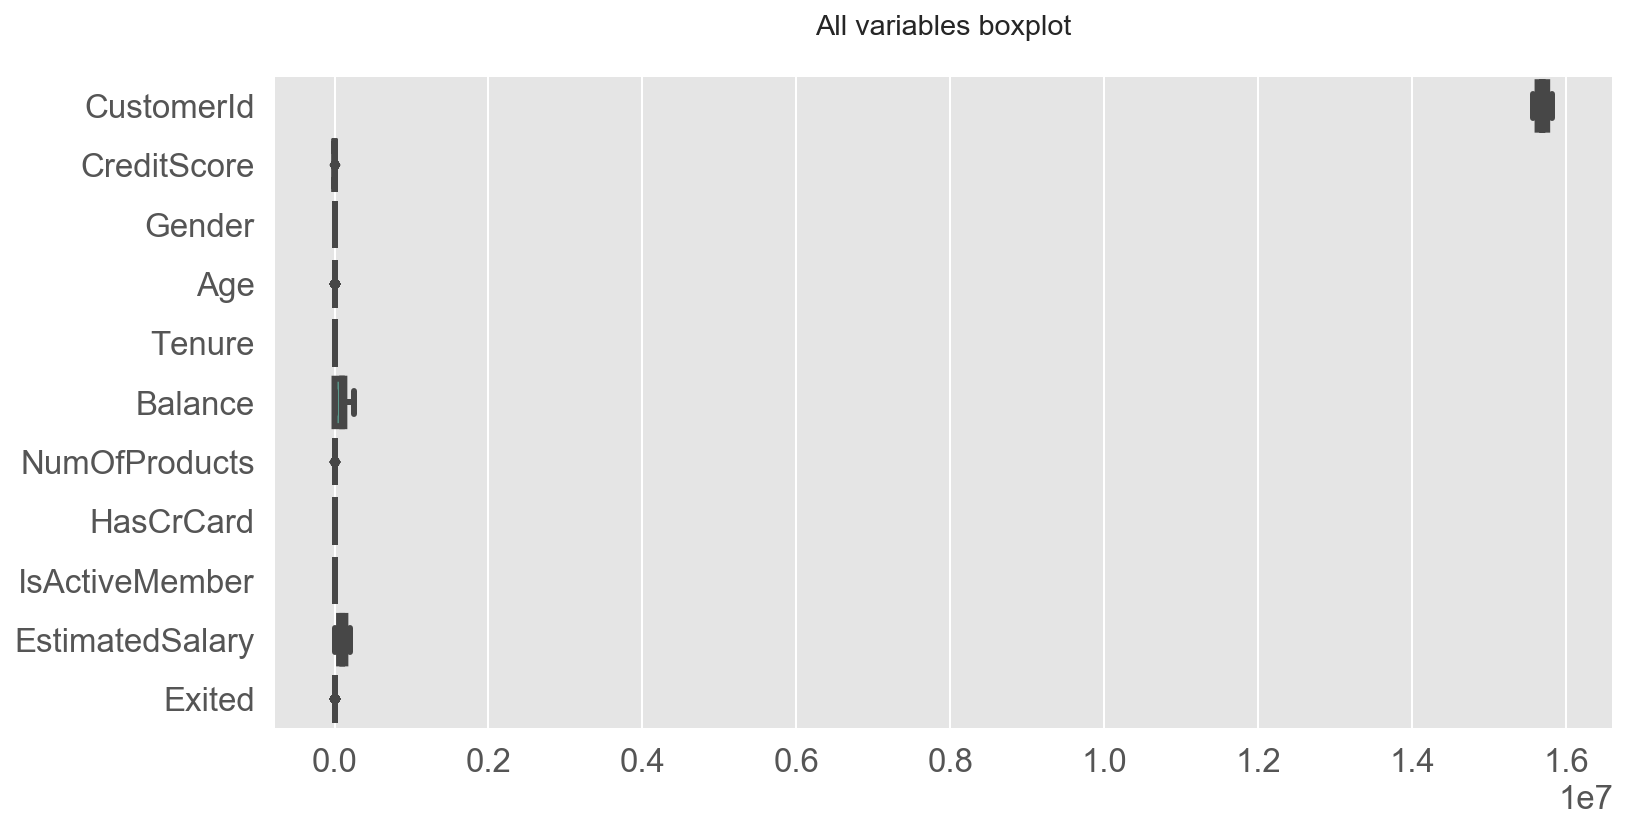

In [159]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()

sns.boxplot(data=df, orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')
plt.show()

#### Standarize Our Data

In [160]:
def var_standardized(var):
    var_stand = (var-var.mean())/var.std()
    return var_stand

In [161]:
df_stand = var_standardized(df.select_dtypes(np.number))

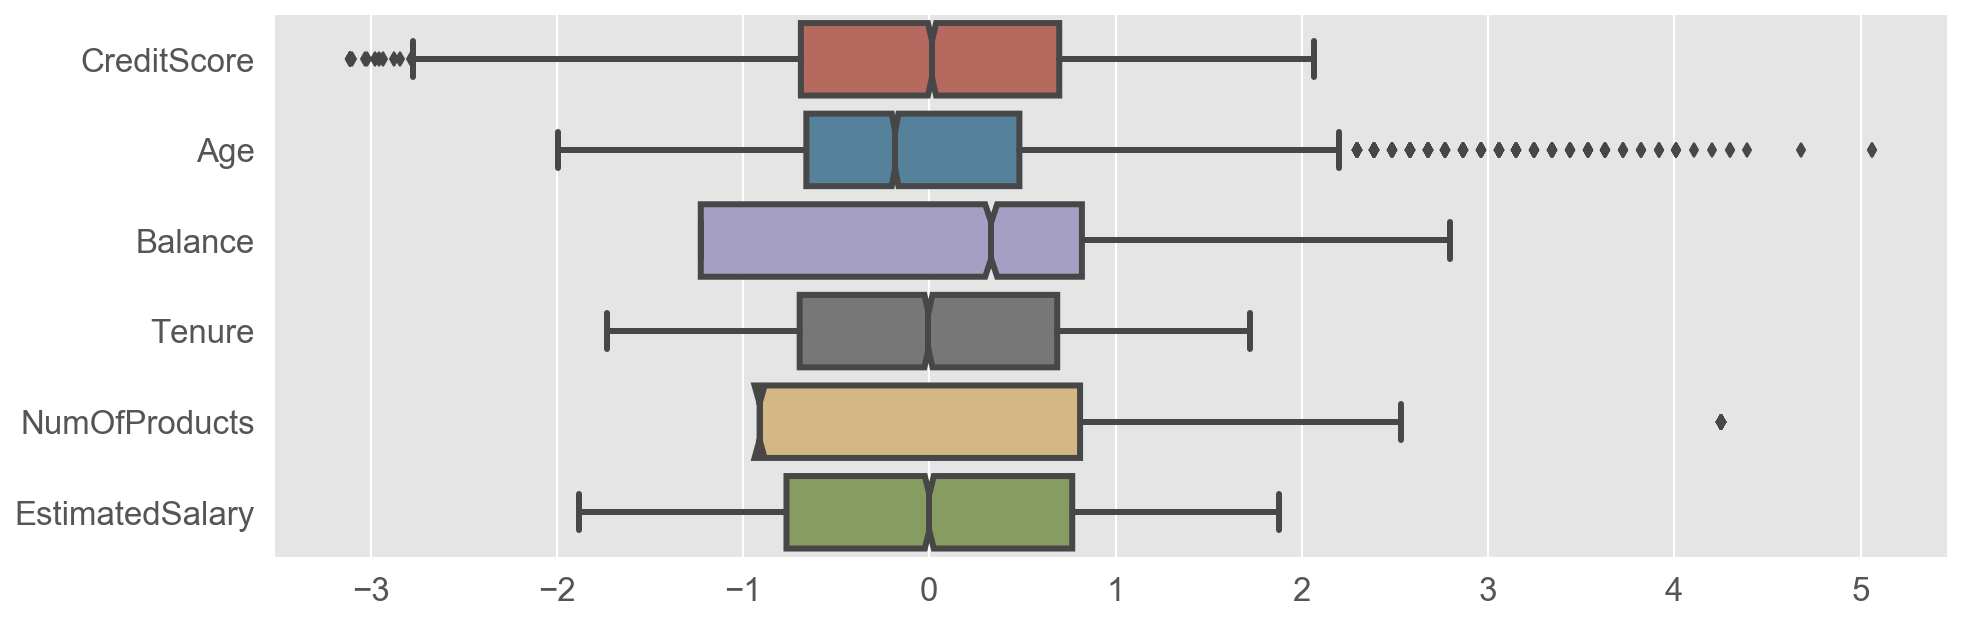

In [168]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

sns.boxplot(data=df_stand[['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']],
            orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

From the plot above, it looks like we have outliers in Age, Num of Products, and Credit Score

##### Removing Outliers

In [169]:
#Here we define a function to remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [170]:
# we create a copy to test first
df_c = df.copy()

In [171]:
df_c.shape

(9975, 13)

In [172]:
# we remove the outlier from the copy dataset and then check how many observations were dropped
df_c = remove_outlier(df_c, 'Age')
df_c = remove_outlier(df_c, 'CreditScore')
df_c = remove_outlier(df_c, 'NumOfProducts')
df_c.shape

(9491, 13)

only 484 observations were dropped, so it is okay

In [173]:
dfc_stand = var_standardized(df_c.select_dtypes(np.number))

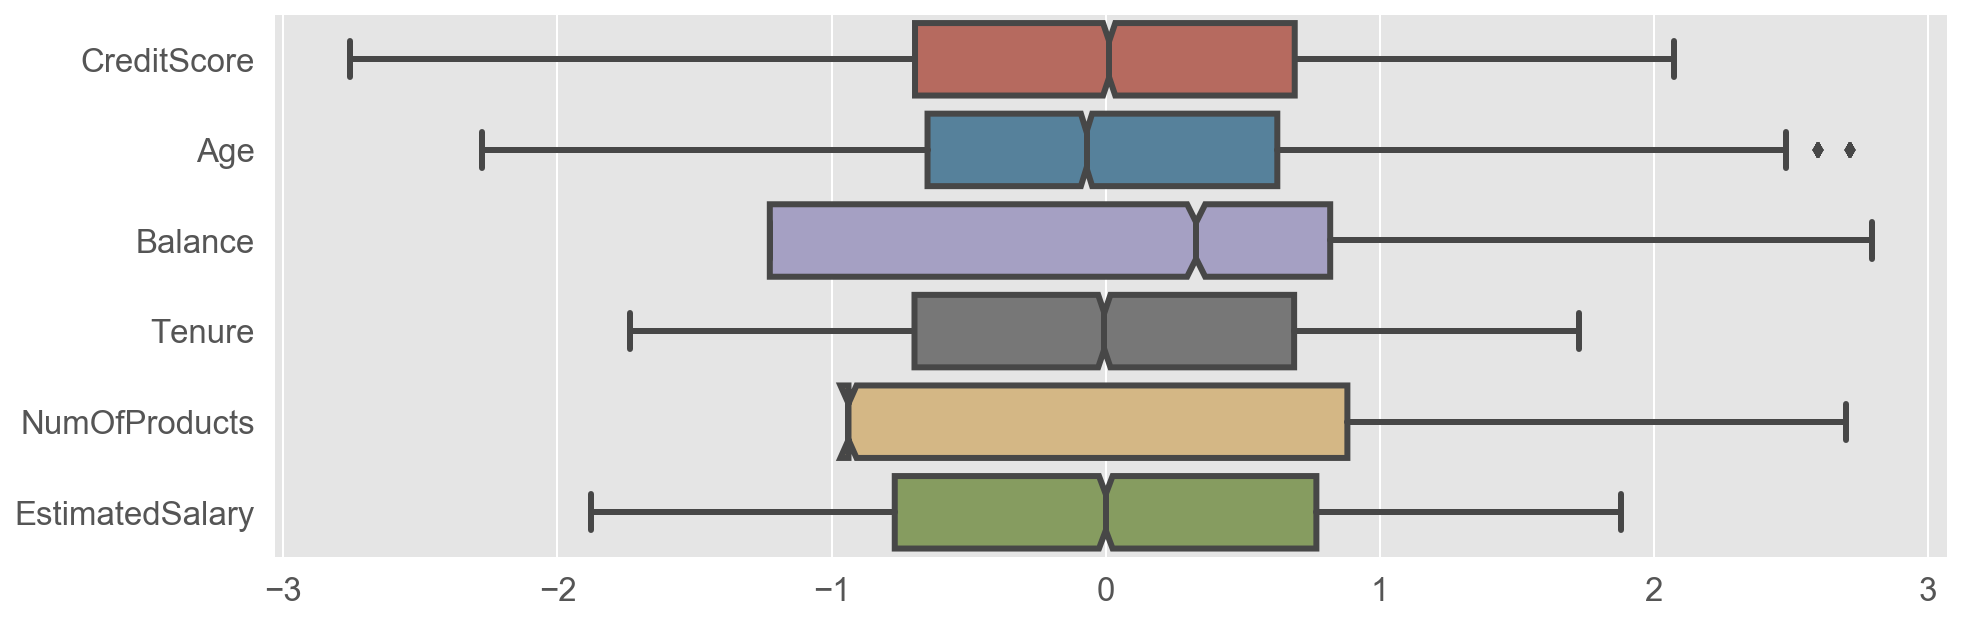

In [177]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

sns.boxplot(data=dfc_stand[['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']],
            orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

In [178]:
df_c.dropna().shape

(8128, 13)

The final clean data set now has 8128 rows out of 10,000. We dropped about 19% of the data. It might be worth while to see if the data we dropped belong mostly to Exited=1, if so it might be better to see if we can find the data  somehow either. 

The data seem to represent some sort of a financial instituion that offer a few products, most likley, a bank from the information we have on the customers such as balance and credit score. The Exited variable might mean they left the bank/closed account. The data we have is from France(mostly), Germany, and Spain, so I could assume it's a European Bank/Financial Instituion.

Up to this point, I do not see any clear correlation between any variable and our target variable, therefore Feature Selection will be hard for the next part.

In [ ]:
# SAVE CLEAN DATA to a new file for modelling
df_c.dropna().to_csv('CleanChurn.csv')

##### Please continue to the modelling notebook 